In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

import plotnine as p9
import matplotlib.pyplot as plt

import liana as li
import decoupler as dc
# import omnipath as op

import corneto as cn

import glob
import os

In [4]:
adata = ...

In [17]:
groupby = 'manual_celltype_annotation'

lr_res_output = 'lr_res.pkl.gz'
dea_df_output = 'dea_df.pkl.gz'
lr_res_txt_output_prefix = 'lr_res'

tret = "HCM"
ctrl = "HEALTHY"

In [6]:
# List all file paths
file_paths = glob.glob(f"../DE-*/DEA.{tret}_vs_{ctrl}/top.table.{tret}_vs_{ctrl}_all.tsv")

# Initialize an empty list to store DataFrames
dfs = []

for file_path in file_paths:
    # Extract the manual_celltype_annotation from the file path
    manual_celltype_annotation = os.path.basename(os.path.dirname(os.path.dirname(file_path)))
    
    # Remove the prefix 'DE_GSEA-' from the annotation
    manual_celltype_annotation = manual_celltype_annotation.replace('DE-', '')
    
    # Step 3: Read the file into a DataFrame
    df = pd.read_csv(file_path, sep='\t')
    
    # Add the manual_celltype_annotation column
    df[groupby] = manual_celltype_annotation
    
    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames into one
dea_df = pd.concat(dfs)

# Set 'gene_names' as the index
dea_df.set_index('gene_names', inplace=True)

# Remove the index name
dea_df.index.name = None

# Reorder the DataFrame to make 'manual_celltype_annotation' the first column
columns_order = [groupby] + [col for col in dea_df.columns if col != groupby]
dea_df = dea_df[columns_order]

dea_df[groupby] = dea_df[groupby].astype('category')

# Convert the rest of the column types to float
# Here we exclude 'manual_celltype_annotation' from conversion as it should be a category
for col in dea_df.columns[1:]:  # Excluding 'manual_celltype_annotation' which is now the first column
    dea_df[col] = dea_df[col].astype(float)

# Rename specific columns
dea_df.rename(columns={'t': 'stat', 'P.Value': 'pvalue', 'adj.P.Val': 'padj'}, inplace=True)

# Keep only the columns 'stat', 'pvalue', 'padj'
dea_df = dea_df[[groupby, 'stat', 'pvalue', 'padj']]

In [9]:
# Filter both to make them with the same number
filtered_df = dea_df[~dea_df[groupby].isin(['All_macrophages', 'All_lymphocytes', 'All_fibroblasts'])]
adata_filtered = adata[~adata.obs[groupby].isin([])].copy()

# DEA to LR interactions

In [12]:
lr_res = li.multi.df_to_lr(adata_filtered,
                           dea_df=filtered_df,
                           resource_name='consensus', # mouseconsensus or consensus
                           expr_prop=0.1, # calculated for adata as passed - used to filter interactions
                           groupby=groupby,
                           stat_keys=['stat', 'pvalue', 'padj'],
                           use_raw=False,
                           complex_col='stat', 
                           verbose=True,
                           return_all_lrs=False,
                           layer='logcounts'
                           )

Using resource `consensus`.
Using the `logcounts` layer!
Converting to sparse csr matrix!
/users/procardis/zlv560/workspace/__PYVENV/CCC/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
130 features of mat are empty, they will be removed.
/users/procardis/zlv560/workspace/__PYVENV/CCC/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/users/procardis/zlv560/workspace/__PYVENV/CCC/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
Features in adata and dea_df are mismatched.
0.05 of entities in the resource are missing from the data.

In [18]:
# computing results
lr_res = lr_res.sort_values("interaction_stat", ascending=False, key=abs)

# Filter the DataFrame where interaction_padj < 0.05
filtered_lr_res = lr_res[lr_res['interaction_padj'] < 0.05]

In [19]:
# Let's visualize how this looks like for all interactions  (across all cell types)
lr_res = lr_res.sort_values("interaction_stat", ascending=False)

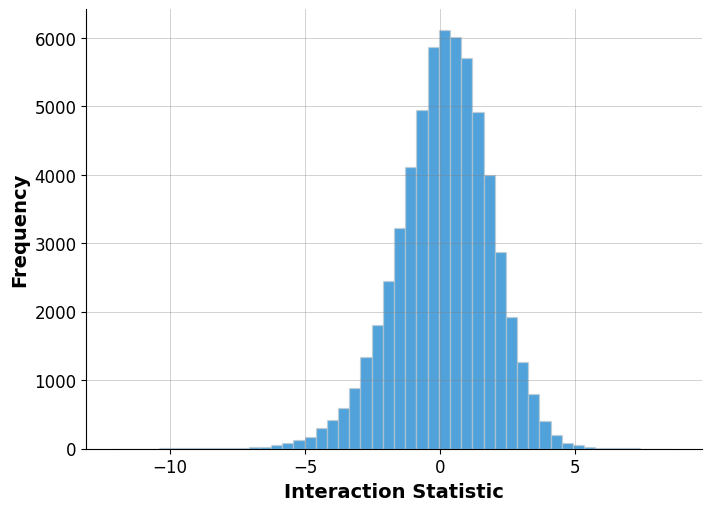

In [20]:
# Set the size of the figure and enable constrained layout
plt.figure(figsize=(7, 5), constrained_layout=True)  # width: 10 inches, height: 6 inches

# Plot the histogram with the main color set to #51A2DA
# Note: The '#' is necessary when specifying hexadecimal colors
plt.hist(lr_res['interaction_stat'], bins=50, color='#51A2DA', edgecolor=(0.8, 0.8, 0.8, 0.5))

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adding aesthetics to make the plot prettier
# plt.title('Distribution of Interaction Statistics')  # Title of the histogram
plt.xlabel('Interaction Statistic', fontsize=14, fontweight='bold')  # X-axis label
plt.ylabel('Frequency', fontsize=14, fontweight='bold')  # Y-axis label

# Increase the size of the axis tick numbers
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add the main grid with less visibility
plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

# Save the figure as a PDF with the desired size
plt.savefig('interaction_statistics.pdf', format='pdf')

# Show the plot
plt.show()

/users/procardis/zlv560/workspace/__PYVENV/CCC/lib/python3.10/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/procardis/zlv560/workspace/__PYVENV/CCC/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'fill' is already present.
Adding another scale for 'fill',
which will replace the existing scale.

/users/procardis/zlv560/workspace/__PYVENV/CCC/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 12 x 8 in image.
/users/procardis/zlv560/workspace/__PYVENV/CCC/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: CCC_plot.pdf
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
Fontsize 0.00 < 1.0

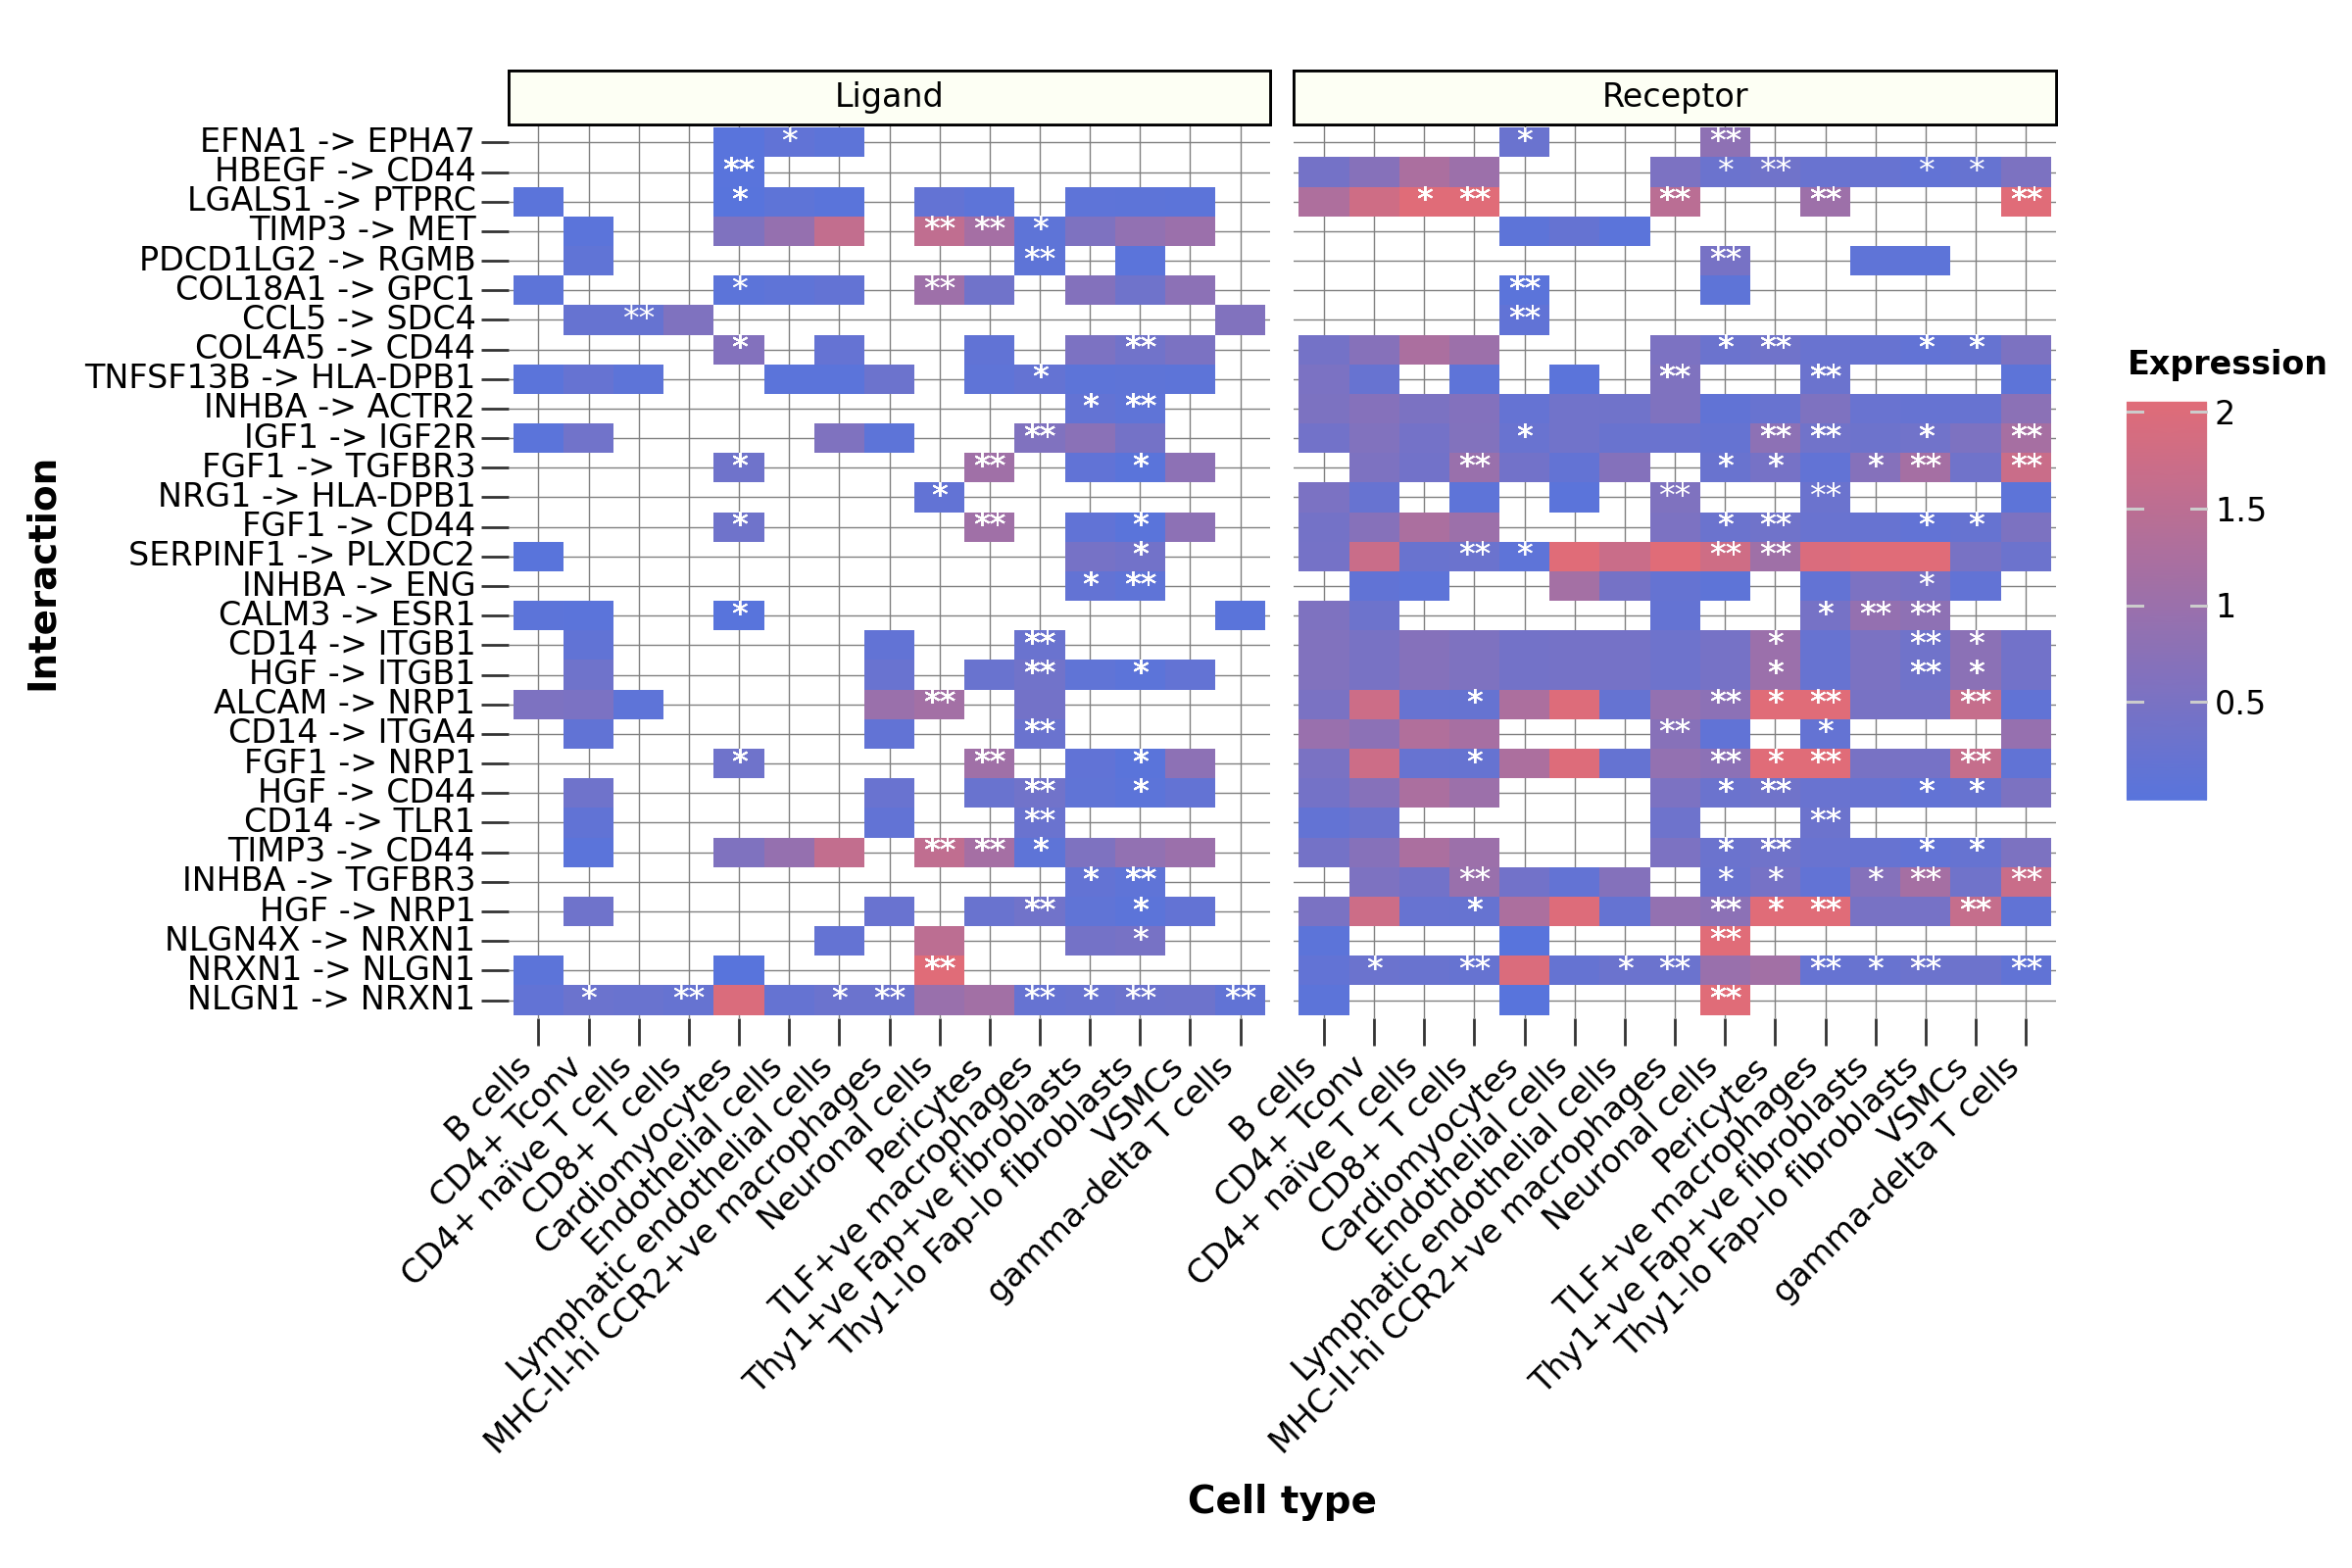

In [21]:
# based on the above distribution, define the `interaction_stat` range
interaction_limit = 2

# Generate the tileplot with basic setup
plot = li.pl.tileplot(liana_res=lr_res,
                      fill='expr',
                      label='padj',
                      label_fun=lambda x: '**' if x < 0.01 else ('*' if x < 0.05 else ''),
                      top_n=30,
                      orderby='interaction_stat',
                      orderby_ascending=False,
                      orderby_absolute=False,
                      source_title='Ligand',
                      target_title='Receptor')

# Enhance the plot
enhanced_plot = (plot
                 + p9.theme(figure_size=(12, 8),  # Adjust figure size
                            text=p9.element_text(size=12, color='black'),  # Adjust base text size and color
                            axis_title=p9.element_text(size=14, weight='bold', color='black'),  # Bold and black axis titles
                            axis_text_x=p9.element_text(angle=45, hjust=1, color='black'),  # Rotate x-axis labels for better readability and black color
                            axis_text_y=p9.element_text(color='black'),  # Black y-axis labels
                            legend_title=p9.element_text(weight='bold', margin={'b': 10}),  # Bold legend title with bottom margin adjustment
                            panel_grid_major=p9.element_line(color='grey', size=0.5),  # Adjust grid line color and size
                            panel_grid_minor=p9.element_blank(),  # Remove minor grid lines
                            panel_border=p9.element_blank(),  # Remove panel border to address spine removal partially
                            axis_ticks_length_major=10)  # Adjust tick length for better grid alignment
                 + p9.scale_fill_gradient(low='#5874DC', high='#E06C78', limits=(None, interaction_limit))  # Adjusted color gradient with max limit
                 + p9.guides(fill=p9.guide_colorbar(ticks=True, title='Expression'))  # Include ticks in the colorbar and adjust title with newlines for spacing
                )

# Save the enhanced plot to a PDF file with specific dimensions
enhanced_plot.save('CCC_plot.pdf', width=12, height=8, units='in')

# Display the plot
print(enhanced_plot)

/users/procardis/zlv560/workspace/__PYVENV/CCC/lib/python3.10/site-packages/liana/plotting/_common.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/users/procardis/zlv560/workspace/__PYVENV/CCC/lib/python3.10/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_color_cmap could not recognise parameter `midpoint`
/users/procardis/zlv560/workspace/__PYVENV/CCC/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

/users/procardis/zlv560/workspace/__PYVENV/CCC/lib/python3.10/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'size' is already present.
Adding another scale for 'siz

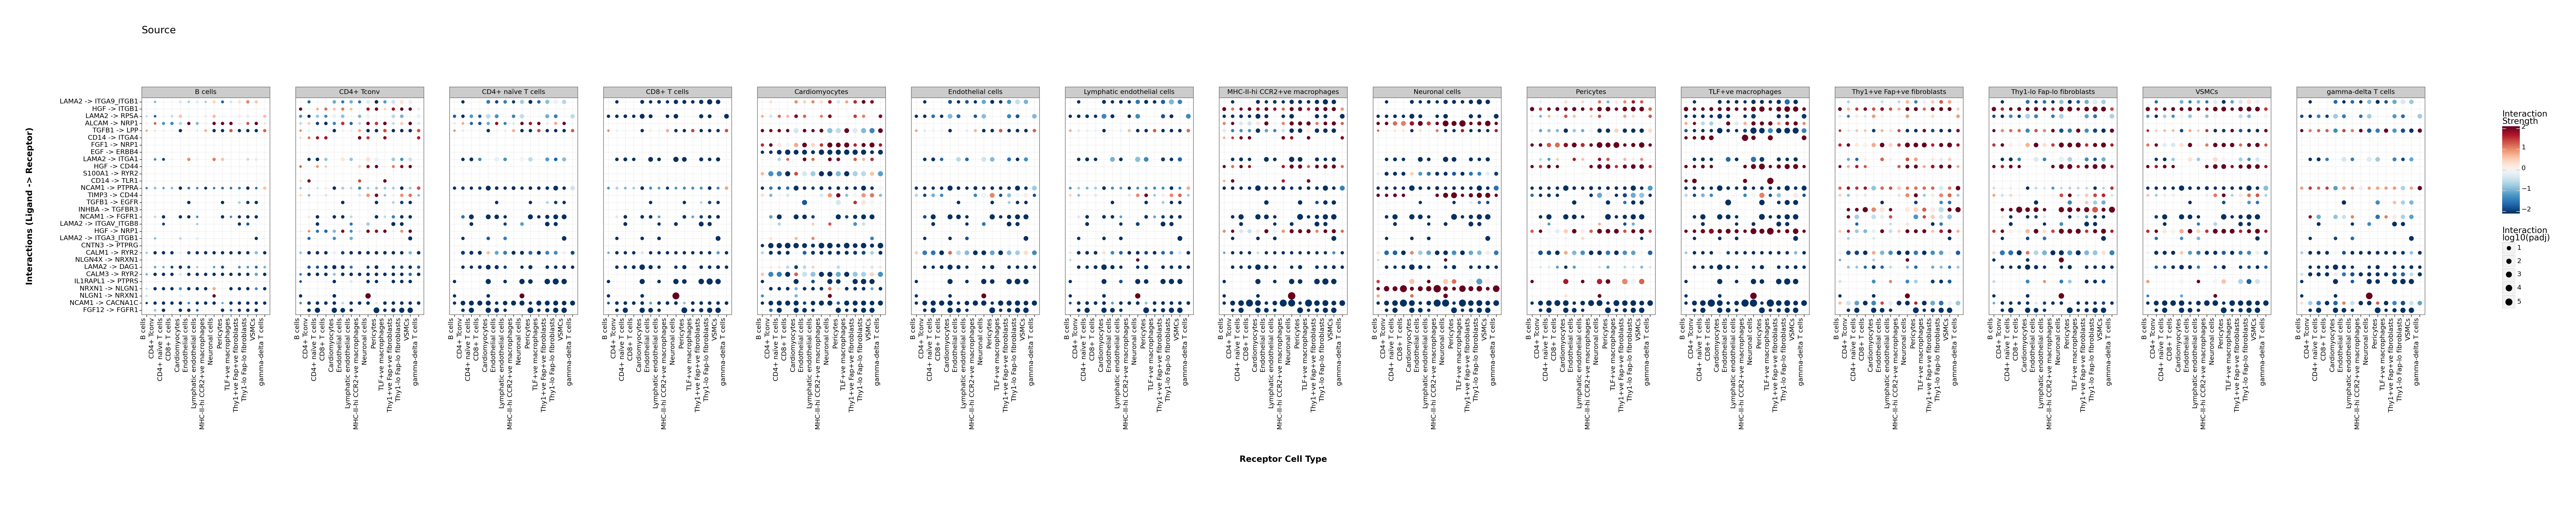

In [22]:
plot = li.pl.dotplot(liana_res=lr_res,
                     colour='interaction_stat',
                     size='interaction_padj',
                     inverse_size=True,
                     orderby='interaction_stat',
                     orderby_ascending=False,
                     orderby_absolute=True,
                     top_n=30,
                     size_range=(0.5, 4)
                     )

# customize plot
enhanced_plot = (
    plot
    + p9.theme_bw(base_size=14)
    # fill cmap blue to red, with 0 the middle
    + p9.scale_color_cmap('RdBu_r', 
                          midpoint=0, 
                          limits=(-interaction_limit, interaction_limit),
                          name="Interaction\nStrength")
    + p9.scale_size(name="Interaction\nlog10(padj)")
    # rotate x
    + p9.theme(axis_text_x=p9.element_text(angle=90, hjust=1, color='black'), 
               figure_size=(60, 12),
               text=p9.element_text(color='black'),
               axis_title=p9.element_text(weight='bold', color='black'),
               axis_text_y=p9.element_text(color='black'),
               legend_title=p9.element_text(margin={'b': 10}),
               panel_grid_major=p9.element_line(color='lightgrey', size=0.5, alpha=0.5),
               panel_grid_minor=p9.element_blank())
    # Update axis titles and remove plot title
    + p9.labs(x="Receptor Cell Type", 
              y="Interactions (Ligand -> Receptor)", title=None)
)

# Save the enhanced plot to a PDF file with specific dimensions
enhanced_plot.save('CCC_dotplot.pdf', limitsize=False)

# Display the plot
print(enhanced_plot)